# 테마주 지수 만들기

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [3]:
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time

In [4]:
import FinanceDataReader as fdr

stocklst = fdr.StockListing('KRX')  # stocklst = 한국 전체 주식
stocklst.head()

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,전자부품 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,김세완,http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,박대현,http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도


# 테마주 지수구하기: 가뭄

##  수도관 관련주 (df_index1)

In [46]:
# 지수 구하기 
driver = webdriver.Chrome()

company_lst = [
# 수도관 주
'뉴보텍', #- 상하수관 및 하수정비

'동양철관',  #- 수도관 및 배관용 장비 제조 및 판매

'뉴로스', #- 상하수도 및 수처리

'자연과환경', # - 4대강 관련주


'웰크론한텍' #- 폐수처리 및 담수처리 전문업체
]

codes_lst = stocklst[stocklst.Name.apply(lambda stock: stock in company_lst)].Symbol.to_list()  #Symbol = 코드
# print(len(codes_lst)) # codes 의 길이가 company lst 의 길이가 같아야 정상적으로 나온거임 
# codes_lst

marketcap = dict()

for code in codes_lst:
    print(code)
    df_p = fdr.DataReader(code,'2016-01-01', '2018-12-31')
        
    #기준시점 시가 총액(시작날짜)
    price1 = df_p.loc['2016-01-04']['Close']
    
    url1 = 'https://navercomp.wisereport.co.kr/v2/company/c1010001.aspx?cmp_cd={}'.format(code)
    driver.get(url1)
    time.sleep(0.5)
    html1 = driver.page_source
    df1 = pd.read_html(html1)[1]
   
    # 발행 주식수
    outstanding = df1.iloc[6][1].split('/')[0]
    outstanding = outstanding.replace('주','') # 1,231,000주 -> 1,231,000
    outstanding = outstanding.replace(',', '') # 1,231,000 -> 1231000
    outstanding =  float(outstanding)
    print("발행 주식수: ",outstanding)
    
    # 유동비율 
    floating = df1.iloc[6][1].split('/')[1]
    floating = floating.replace('%', '')  # %기호 없애주기
    floating = float(floating)
    print("유동비율: ",floating)
    
     #액면가
    price_f = df1.iloc[2][1]
    price_f = price_f.replace('원', '') # 5,000원 -> 5,000
    price_f = price_f.replace(',', '') # 5,000 -> 5000
    price_f = int(price_f)
    print("액면가: ", price_f)
    print('-'* 50)
    
    ## 지수 구하기
    
    # 기업들의 주가 데이터프레임: df_p
#     df_p = fdr.DataReader(code,'2018-01-01', '2018-12-31')
    
    #비교시점의 시가총액(비교시점주가 * 발행주식수 * 유동비율)
    
    if price_f == 5000:     #액면금액이 5000원
        pass
    
    elif price_f == 2500:   #액면금액이 2500원
        df_p['Close'] = df_p['Close']/2
        
    elif price_f == 500:    #액면금액이 500원
        df_p['Close'] = df_p['Close']/10
        
    elif price_f == 100:    #액면금액이 100원
        df_p['Close'] = df_p['Close']/50
        
   # 회사코드 -> 회사명
    company_name = stocklst[stocklst['Symbol']== str(code)]['Name'].values[0]
    
    # 회사의 시가총액 계산
    marketcap[company_name] = df_p['Close'] * outstanding * floating   # 딕셔너리에 추가
   
 
df_index1 = pd.DataFrame(marketcap)
df_index1['total'] = df_index1.sum(axis=1)

# 기준시점 시가총액 ( 기준시점주가 * 발행주식수 * 유동비율)

marketcap_std = df_index1['total'].iloc[0]

# 지수 = (각기업시가총액합 / 2019년 1월2일의 각 기업시가총액합) * 100
df_index1['지수'] = (df_index1['total']/ marketcap_std) * 100

df_index1.reset_index(inplace=True)
df_index1.head()





    

126870
발행 주식수:  35639394.0
유동비율:  92.89
액면가:  500
--------------------------------------------------
060260
발행 주식수:  33433750.0
유동비율:  71.96
액면가:  500
--------------------------------------------------
008970
발행 주식수:  118885290.0
유동비율:  74.81
액면가:  500
--------------------------------------------------
076080
발행 주식수:  20816746.0
유동비율:  60.63
액면가:  500
--------------------------------------------------
043910
발행 주식수:  81293968.0
유동비율:  94.01
액면가:  500
--------------------------------------------------


,Date,뉴로스,뉴보텍,동양철관,웰크론한텍,자연과환경,total,지수
0,2016-01-04,1.550327e+12,5.081245e+11,1.058363e+12,2.978602e+11,9.575985e+11,4.372274e+12,100.000000
1,2016-01-05,1.570522e+12,5.228005e+11,1.061921e+12,2.909185e+11,9.736476e+11,4.419809e+12,101.087198
2,2016-01-06,1.572177e+12,5.081245e+11,1.034350e+12,2.940738e+11,9.285572e+11,4.337282e+12,99.199699
3,2016-01-07,1.550327e+12,4.985010e+11,1.005890e+12,2.940738e+11,8.987516e+11,4.247544e+12,97.147246
4,2016-01-08,1.528478e+12,4.871933e+11,9.818765e+11,2.865011e+11,8.827025e+11,4.166751e+12,95.299410


##  (df_index2)

In [14]:
# driver = webdriver.Chrome()

# company_lst = [
# # 농약, 비료주
# '경농',
# '조비', 
# '동방아그로',
# '남해화학'
# ]

# codes_lst = stocklst[stocklst.Name.apply(lambda stock: stock in company_lst)].Symbol.to_list()  #Symbol = 코드
# # print(len(codes_lst)) # codes 의 길이가 company lst 의 길이가 같아야 정상적으로 나온거임 
# # codes_lst

# marketcap = dict()

# for code in codes_lst:
# #     df = fdr.DataReader(code,'2021-01-01', '2021-12-31')
        
#     #기준시점 시가 총액(시작날짜)
#     price1 = df.loc['2018-01-02']['Close']
    
#     url1 = 'https://navercomp.wisereport.co.kr/v2/company/c1010001.aspx?cmp_cd={}'.format(code)
#     driver.get(url1)
#     time.sleep(0.5)
#     html1 = driver.page_source
#     df1 = pd.read_html(html1)[1]
   
#     # 발행 주식수
#     outstanding = df1.iloc[6][1].split('/')[0]
#     outstanding = outstanding.replace('주','') # 1,231,000주 -> 1,231,000
#     outstanding = outstanding.replace(',', '') # 1,231,000 -> 1231000
#     outstanding =  float(outstanding)
#     print("발행 주식수: ",outstanding)
    
#     # 유동비율 
#     floating = df1.iloc[6][1].split('/')[1]
#     floating = floating.replace('%', '')  # %기호 없애주기
#     floating = float(floating)
#     print("유동비율: ",floating)
    
#      #액면가
#     price_f = df1.iloc[2][1]
#     price_f = price_f.replace('원', '') # 5,000원 -> 5,000
#     price_f = price_f.replace(',', '') # 5,000 -> 5000
#     price_f = int(price_f)
#     print("액면가: ", price_f)
#     print('-'* 50)
    
#     ## 지수 구하기
    
#     # 기업들의 주가 데이터프레임: df_p
#     df_p = fdr.DataReader(code,'2018-01-01', '2018-12-31')
    
#     #비교시점의 시가총액(비교시점주가 * 발행주식수 * 유동비율)
    
#     if price_f == 5000:     #액면금액이 5000원
#         pass
#     elif price_f == 2500:   #액면금액이 2500원
#         df_p['Close'] = df_p['Close']/2
        
#     elif price_f == 500:    #액면금액이 500원
#         df_p['Close'] = df_p['Close']/10
        
#     elif price_f == 100:    #액면금액이 100원
#         df_p['Close'] = df_p['Close']/50
        
#    # 회사코드 -> 회사명
#     company_name = stocklst[stocklst['Symbol']== str(code)]['Name'].values[0]
    
#     # 회사의 시가총액 계산
#     marketcap[company_name] = df_p['Close'] * outstanding * floating   # 딕셔너리에 추가
   
 
# df_index2 = pd.DataFrame(marketcap)
# df_index2['total'] = df_index2.sum(axis=1)

# # 기준시점 시가총액 ( 기준시점주가 * 발행주식수 * 유동비율)

# marketcap_std = df_index2['total'].iloc[0]

# # 지수 = (각기업시가총액합 / 2019년 1월2일의 각 기업시가총액합) * 100
# df_index2['지수'] = (df_index2['total']/ marketcap_std) * 100

# df_index2.reset_index(inplace=True)
# df_index2.head()


## 제습기 주

In [15]:
# driver = webdriver.Chrome()

# company_lst = [
# # 제습기 주
# '위닉스',
# '신일전자',
# '파세코',
# '코웨이'
# ]

# codes_lst = stocklst[stocklst.Name.apply(lambda stock: stock in company_lst)].Symbol.to_list()  #Symbol = 코드
# # print(len(codes_lst)) # codes 의 길이가 company lst 의 길이가 같아야 정상적으로 나온거임 
# # codes_lst

# marketcap = dict()

# for code in codes_lst:
# #     df = fdr.DataReader(code,'2021-01-01', '2021-12-31')
        
#     #기준시점 시가 총액(시작날짜)
#     price1 = df.loc['2018-01-02']['Close']
    
#     url1 = 'https://navercomp.wisereport.co.kr/v2/company/c1010001.aspx?cmp_cd={}'.format(code)
#     driver.get(url1)
#     time.sleep(0.5)
#     html1 = driver.page_source
#     df1 = pd.read_html(html1)[1]
   
#     # 발행 주식수
#     outstanding = df1.iloc[6][1].split('/')[0]
#     outstanding = outstanding.replace('주','') # 1,231,000주 -> 1,231,000
#     outstanding = outstanding.replace(',', '') # 1,231,000 -> 1231000
#     outstanding =  float(outstanding)
#     print("발행 주식수: ",outstanding)
    
#     # 유동비율 
#     floating = df1.iloc[6][1].split('/')[1]
#     floating = floating.replace('%', '')  # %기호 없애주기
#     floating = float(floating)
#     print("유동비율: ",floating)
    
#      #액면가
#     price_f = df1.iloc[2][1]
#     price_f = price_f.replace('원', '') # 5,000원 -> 5,000
#     price_f = price_f.replace(',', '') # 5,000 -> 5000
#     price_f = int(price_f)
#     print("액면가: ", price_f)
#     print('-'* 50)
    
#     ## 지수 구하기
    
#     # 기업들의 주가 데이터프레임: df_p
#     df_p = fdr.DataReader(code,'2018-01-01', '2018-12-31')
    
#     #비교시점의 시가총액(비교시점주가 * 발행주식수 * 유동비율)
    
#     if price_f == 5000:     #액면금액이 5000원
#         pass
#     elif price_f == 2500:   #액면금액이 2500원
#         df_p['Close'] = df_p['Close']/2
        
#     elif price_f == 500:    #액면금액이 500원
#         df_p['Close'] = df_p['Close']/10
        
#     elif price_f == 100:    #액면금액이 100원
#         df_p['Close'] = df_p['Close']/50
        
#    # 회사코드 -> 회사명
#     company_name = stocklst[stocklst['Symbol']== str(code)]['Name'].values[0]
    
#     # 회사의 시가총액 계산
#     marketcap[company_name] = df_p['Close'] * outstanding * floating   # 딕셔너리에 추가
   
 
# df_index3 = pd.DataFrame(marketcap)
# df_index3['total'] = df_index3.sum(axis=1)

# # 기준시점 시가총액 ( 기준시점주가 * 발행주식수 * 유동비율)

# marketcap_std = df_index3['total'].iloc[0]

# # 지수 = (각기업시가총액합 / 2019년 1월2일의 각 기업시가총액합) * 100
# df_index3['지수'] = (df_index3['total']/ marketcap_std) * 100

# df_index3.reset_index(inplace=True)
# df_index3.head()


# 지수변동률 추가

In [309]:
# 지수변동률 추가

# diff_lst = [0]
# for i in range(len(df_marketcap)-1):
#     diff = (df_marketcap['지수'].iloc[i+1]-df_marketcap['지수'].iloc[i])*100/df_marketcap['지수'].iloc[i]
#     diff_lst.append(diff)
# len(diff_lst)

# df_marketcap['지수변동률'] = diff_lst
# df_marketcap.reset_index(inplace=True)
# df_marketcap.head(2)

In [310]:
# df_scaler = df_marketcap.copy()
# df_scaler.head(2)

# 시각화

## matplotlib

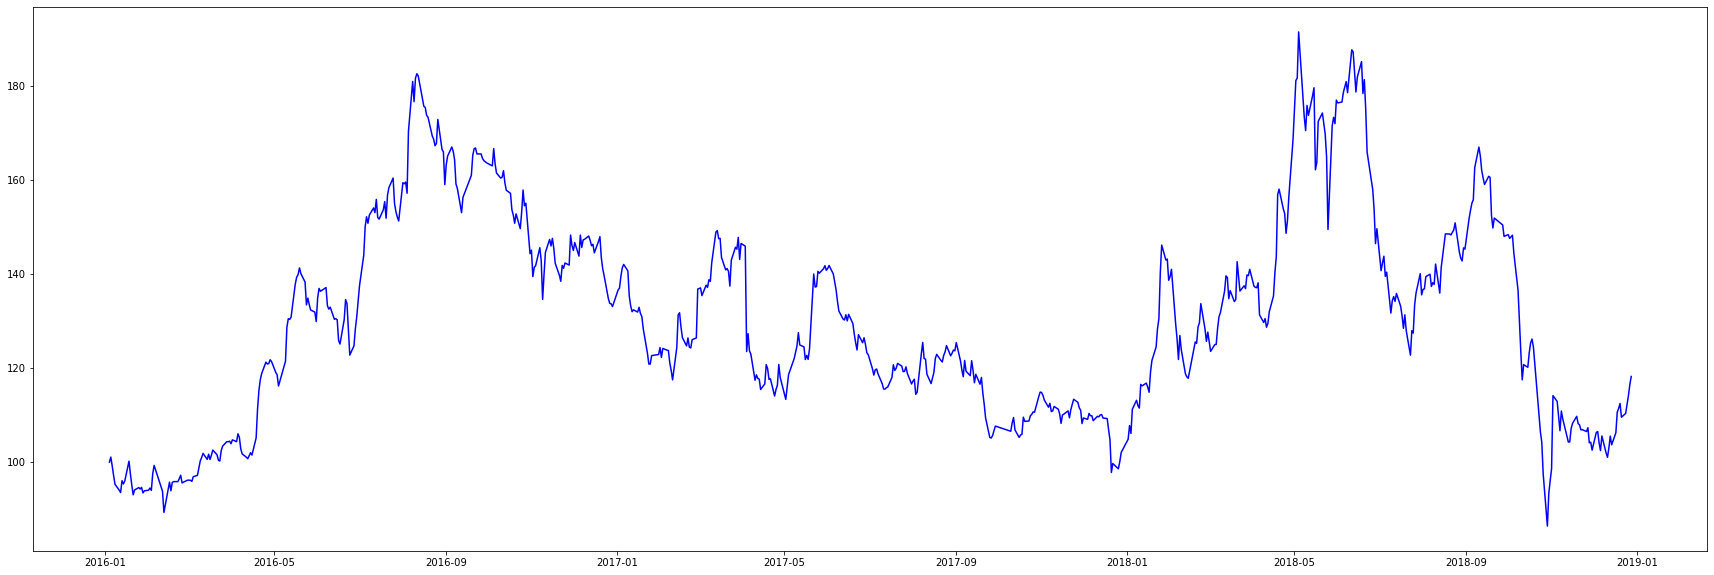

In [22]:
x = df_index1['Date']
y1 = df_index1['지수']
# y2 = df_index2['지수']
# y3 = df_index3['지수']
plt.figure(figsize=(30,10))
plt.plot(x,y1,'b')
#          , x,y2,'g',x,y3,'r')


# y1_scaled = df_scaled.iloc[:,-1]
# y2_scaled = df_scaled.iloc[:,-2]

## plotly

In [23]:
# plotly
# 그래프 하나로 만들기
df_total = pd.DataFrame({'Date': df_index1['Date'], '수도관_지수':df_index1['지수']})
#                          ,'농약비료_지수':df_index2['지수'],'제습기_지수':df_index3['지수']})

fig = px.line(df_total, x='Date', y=['수도관_지수'])

fig.update_xaxes(rangeslider_visible=True)
fig.show()                

In [48]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

df_index11 = df_index1.set_index('Date')
# df_index22 = df_index2.set_index('Date')
# df_index33 = df_index3.set_index('Date')

fig = make_subplots(
    rows=1, cols=3
    ,subplot_titles=("지수_수도관주_2016년",
                    "지수_수도관주_2017년",
                    "지수_수도관주_2018년"))

fig.add_trace(go.Scatter(x= df_index11['2016-04':'2017-04'].index, y=df_index11['지수'].loc['2016-04':'2017-04']),
              row=1, col=1)

fig.add_trace(go.Scatter(x= df_index11['2017-01':'2017-12'].index, y=df_index11['지수'].loc['2017-01':'2017-12']),
              row=1, col=2)

fig.add_trace(go.Scatter(x= df_index11['2018-01':'2018-12'].index, y=df_index11['지수'].loc['2018-01':'2018-12']),
              row=1, col=3)

fig.update_layout(height=500, width=2000,
                  title_text="가뭄 테마주 추세")

# 2016년
# fig.add_vline(x ='2016-08-18')
# fig.add_vline(x ='2016-12-31')

# # 2017년
# fig.add_vline(x ='2017-01-01')
# fig.add_vline(x ='2017-02-18')

# fig.add_vline(x ='2017-04-30')
# fig.add_vline(x ='2017-07-03')

# # 2018년
# fig.add_vline(x ='2018-09-25')
# fig.add_vline(x ='2018-10-13')




fig.show()

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=3, cols=1
    ,subplot_titles=("지수_수도관주_2015년",
                    "지수_수도관주_2016년",
                    "지수_수도관주_2017년"))

fig.add_trace(go.Scatter(x=df_index1['Date'][100:248], y=df_index1['지수'][100:248]),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df_index1['Date'][348:411], y=df_index1['지수'][348:411]),
              row=2, col=1)

fig.add_trace(go.Scatter(x=df_index1['Date'][595:659], y=df_index1['지수'][595:659]),
              row=3, col=1)

fig.update_layout(height=700, width=700,
                  title_text="가뭄 테마주 추세")
fig.show()

## 개별 주식의 추세

In [318]:

stocklst = fdr.StockListing('KRX')
company_lst = [
# 장마 테마주
# (1) 폐기물: 2011년 7월 27일 부근 변동성 큰 주식
'KG ETS',
'인선이엔티',
'와이엔텍',
'코엔텍',
'스페코'

]
codes_lst = stocklst[stocklst.Name.apply(lambda stock: stock in company_lst)].Symbol.to_list() 


price_history = dict()

for code in codes_lst:
    df = fdr.DataReader(code,'2016-01-01', '2018-12-31')
    price_history[code]= df['Close']   # 회사코드: [과거주가 리스트] 
    company_name = stocklst[stocklst['Symbol']== str(code)]['Name'].values[0]
    print('회사이름: ',company_name , '회사코드: ',str(code) )
        
df_p = pd.DataFrame(price_history)
df_p.reset_index(inplace=True)

# 코드 문자열로 바꿔주기
code_str = list(map(str,codes_lst))

fig = px.line(df_p, x='Date', y= code_str)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

회사이름:  KG ETS 회사코드:  151860
회사이름:  스페코 회사코드:  013810
회사이름:  와이엔텍 회사코드:  067900
회사이름:  인선이엔티 회사코드:  060150
회사이름:  코엔텍 회사코드:  029960


In [243]:
#주가 딕셔너리에 넣기-> 유가,개별 주식간 비교에 사용

stocklst = fdr.StockListing('KRX')
company_lst = [
# 장마 테마주
# (2) 농약비료
'경농' ,
# '조비' ,
'동방아그로',
# '남해화학'
]
codes_lst = stocklst[stocklst.Name.apply(lambda stock: stock in company_lst)].Symbol.to_list() 


price_history = dict()

for code in codes_lst:
    df = fdr.DataReader(code,'2011-01-01', '2011-12-31')
    price_history[code]= df['Close']   # 회사코드: [과거주가 리스트] 
    company_name = stocklst[stocklst['Symbol']== str(code)]['Name'].values[0]
    print('회사이름: ',company_name , '회사코드: ',str(code) )
        
df_p = pd.DataFrame(price_history)
df_p.reset_index(inplace=True)

# 코드 문자열로 바꿔주기
code_str = list(map(str,codes_lst))

fig = px.line(df_p, x='Date', y= code_str)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

회사이름:  경농 회사코드:  002100
회사이름:  동방아그로 회사코드:  007590


In [ ]:
'KG ETS',
'인선이엔티',

=장마
- 폐기물 관련주
'KG ETS'
'인선이엔티'
'와이엔텍' 
# '제넨바이오' *
# '코엔텍'
# '그린플러스' *
'스페코'
'태영건설'

 - 농약/비료
'경농' *
'조비' 
'동방아그로' *
'남해화학'
백광소재
효성오앤비

- 제습기
위닉스
신일전자
파세코
코웨이


남해화학 동방아그로 조비 
파루 경농



= 가뭄
뉴보텍 - 상하수관 및 하수정비

동양철관 - 수도관 및 배관용 장비 제조 및 판매

뉴로스 - 상하수도 및 수처리

자연과환경 - 4대강 관련주

CSA코믹스 - 수처리

웰크론한텍 - 폐수처리 및 담수처리 전문업체


열대야 테마주 
'신일전자'
'파세코'
'에스씨디'
'빙그레'
'위닉스'
'태경케미컬'
'위니아딤채'
'에스피지'
'롯데하이마트'
'비엠티'

## 코스피, 코스닥 지수

In [307]:
# df_index = fdr.DataReader('KS100','2019-01-01','2019-12-31') 왜 안될까

## 다음날 아침 급등주 캐치 전략

In [75]:
df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2019-01-02,5760,5880,5650,5650,22922,-0.013962
2019-01-03,5650,5900,5620,5730,37716,0.014159
2019-01-04,5770,5770,5590,5690,37358,-0.006981
2019-01-07,5730,5870,5700,5800,35747,0.019332
2019-01-08,5940,6340,5860,6200,178631,0.068966


In [78]:
# 전날 종가 다음날 고가 변동률

diff_history = dict()

for code in codes_fire:
    df = fdr.DataReader(code,'2019-01-02', '2019-12-31')
    diff_history[code]= df['Change']   # 회사코드: [과거주가 리스트] 

df_diff = pd.DataFrame(diff_history)
df_diff

,014200,067170,074610,083640,033540,010040,041440
Date,,,,,,,
2019-01-02,0.000000,0.023810,-0.038869,0.000000,0.018182,-0.059783,-0.013962
2019-01-03,0.000000,0.013953,0.000000,-0.047945,-0.023214,0.021195,0.014159
2019-01-04,0.024048,0.036697,0.042279,0.017986,-0.018282,-0.001887,-0.006981
2019-01-07,-0.007828,0.000000,0.169312,0.000000,0.018622,0.068053,0.019332
2019-01-08,0.001972,0.013274,-0.072398,0.028269,0.012797,-0.017699,0.068966
...,...,...,...,...,...,...,...
2019-12-23,-0.017429,0.017937,-0.035135,-0.036918,0.030635,-0.025579,-0.002227
2019-12-24,-0.024390,-0.008811,-0.008403,-0.031111,-0.010616,-0.020000,-0.006696
2019-12-26,0.031818,0.017778,0.032486,0.028670,-0.017167,0.019133,-0.004494


In [ ]:
# 구제역 관련주
# 대체식품(수산업,닭)
: 한성기업,정다운,동우팜투테이블,사조오양, 
신라교역, 마니커, 동원산업 
신라에스지 
하림 
동원수산 
이지홀딩스
팜스토리


# 사료
한일사료

# 백신
우성사료 우진비앤지 대성미생물 

# 석회
태경비케이 



In [ ]:
# ai 관련주(주로 백신) : ai가 길어지면 대체식품주 오를 수 있음

파루
제일바이오
이글벳
진원생명과학
팜스웰바이오
씨티씨바이오
대한뉴팜

